In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [3]:
def normalizeSpread(spread, ask): #making a function to convert spreads from price space to percentage space, and eliminating all negative spreads
    if ask==0:
        return np.nan
    elif ask>0:
        return float(spread/ask)
    elif spread<0:
        return 0.

In [4]:
def splitData(data, features, target, test_fraction, set_seed=False):
    #splitting data into train and test
    x=data[features]
    y=data[target]
    if set_seed==True:
        x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=test_fraction, shuffle=True, random_state='12262021')
    else:
        x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=test_fraction, shuffle=True)
    return (x_train, x_test, y_train, y_test)

In [5]:
def randomForestFitter(DataSet, symbol, features, target, depth, set_seed=False):
    #fit raw data to random forest
    
    #get data only for particular symbol
    DataSet=DataSet[DataSet['symbol']==symbol]
    
    #split data
    (x_train, x_test, y_train, y_test)=splitData(DataSet, staticFeatures, target, test_fraction=0.2)

    #fit random forest
    Predictor=RandomForestRegressor(max_depth=depth).fit(x_train, y_train)
    y_train_pred=Predictor.predict(x_train)
    y_test_pred=Predictor.predict(x_test)
    
    #evaluate error
    training_error=np.sqrt(metrics.mean_squared_error(y_train_pred, y_train))/(DataSet[target].std())
    test_error=np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))/(DataSet[target].std())
    
    #return trained forest and errors
    return (Predictor, training_error, test_error)

In [6]:
def pcaRandomForestFitter(DataSet, symbol, features, target, depth, cutoff,set_seed=False):
    #get only data for a particular symbol and split into train and test
    DataSet=DataSet[DataSet['symbol']==symbol]
    x_train, x_test, y_train, y_test=splitData(DataSet, staticFeatures, target, test_fraction=0.2) 
    
    #rescale data and perform pca, attempting to explain the variance to some cutoff
    scaler=StandardScaler()
    scaler.fit(x_train)
    x_train=scaler.transform(x_train)
    x_test=scaler.transform(x_test)
    
    pca=PCA(cutoff)
    pca.fit(x_train)
    x_train=pca.transform(x_train)
    x_test=pca.transform(x_test)
    
    Predictor=RandomForestRegressor(max_depth=depth).fit(x_train, y_train)
    y_train_pred=Predictor.predict(x_train)
    y_test_pred=Predictor.predict(x_test)
    
    #evaluate error
    training_error=np.sqrt(metrics.mean_squared_error(y_train_pred, y_train))/(DataSet[DataSet['symbol']==symbol][target].std())
    test_error=np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))/(DataSet[DataSet['symbol']==symbol][target].std())
    
    #return trained forest and errors
    return (Predictor, training_error, test_error)


In [7]:
def LassoFitter(DataSet,symbol_type, features, target, testsize, alpha, set_seed=False):
    DataSet=DataSet[DataSet['symbol_type']==symbol_type]
    x_train, x_test, y_train, y_test=splitData(DataSet, features, target, testsize, set_seed)
    
    Lasso_fit=Lasso(alpha, normalize=True).fit(x_train, y_train)

    return (Lasso_fit, x_train, x_test, y_train, y_test)

In [8]:
def RidgeFitter(DataSet,symbol_type, features, target, testsize, alpha, set_seed=False):
    DataSet=DataSet[DataSet['symbol_type']==symbol_type]
    x_train, x_test, y_train, y_test=splitData(DataSet, features, target, testsize, set_seed)
    
    Ridge_fit=Ridge(alpha, normalize=True).fit(x_train, y_train)
    
    return (Ridge_fit, x_train, x_test, y_train, y_test)

In [ ]:
from tqdm import tqdm

100it [1:08:04, 40.85s/it]


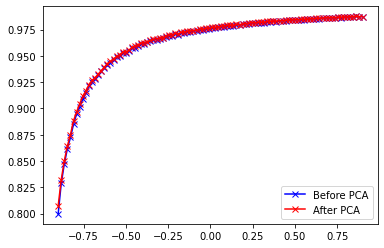

In [10]:
rhos=np.linspace(-0.9,0.9,100)
rsquared=np.zeros(100)
pcarsquared=np.zeros(100)
mean=[0,0]
for index, rho in tqdm(enumerate(rhos)):
    cov=[[1,rho],[rho,1]]
    x=np.random.multivariate_normal(mean, cov, 10**5)
    toydata=pd.DataFrame(x, columns=['x1','x2'])
    toydata['y']=toydata.apply(lambda row: 5*row['x1']+5*row['x2']+np.random.normal(), axis=1)
    
    x_train, x_test, y_train, y_test=train_test_split(toydata[['x1','x2']], toydata['y'], test_size=0.3, shuffle=True)
    Predictor=RandomForestRegressor().fit(x_train, y_train)
    rsquared[index]=Predictor.score(x_test, y_test)
    
    scaler=StandardScaler()
    scaler.fit(x_train)
    pcax_train=scaler.transform(x_train)
    pcax_test=scaler.transform(x_test)
    
    pca=PCA(0.9999)
    pca.fit(pcax_train)
    pcax_train=pca.transform(pcax_train)
    pcax_test=pca.transform(pcax_test)

    Predictor=RandomForestRegressor().fit(pcax_train, y_train)
    pcarsquared[index]=Predictor.score(pcax_test, y_test)

plt.plot(rhos, rsquared, 'x-', color='blue', label='Before PCA')
plt.plot(rhos, pcarsquared, 'x-', color='red', label='After PCA')
plt.legend()

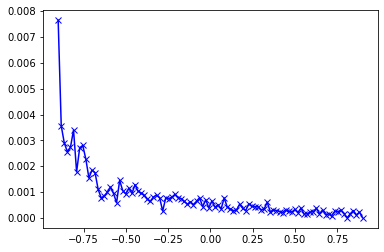

In [11]:
plt.plot(rhos, pcarsquared-rsquared, 'x-', color='blue', label='Before PCA')

100it [29:42, 17.83s/it]


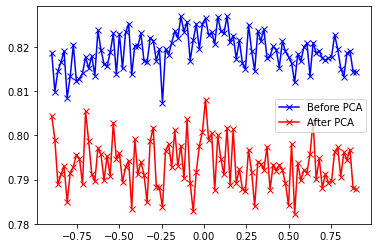

In [17]:
mags=np.linspace(-10,10,100)
measured_corr=np.zeros(100)
rsquared=np.zeros(100)
pcarsquared=np.zeros(100)
mean=[0,0]
cov=[[1,0],[0,1]]
x=np.random.multivariate_normal(mean, cov, 10**5)
toydata=pd.DataFrame(x, columns=['x1','x2'])
toydata['y']=toydata.apply(lambda row: 5*row['x1']+5*row['x2']+np.random.normal(), axis=1)


for index, mag in tqdm(enumerate(mags)):
    toydata['x3']=toydata.apply(lambda row: (row['x1']*row['x2'])+np.random.normal(scale=0.1), axis=1)
    toydata['x4']=toydata.apply(lambda row: (row['x1']/row['x2'])+np.random.normal(scale=0.1)+mag*row['x3'], axis=1)
    
    x_train, x_test, y_train, y_test=train_test_split(toydata[toydata['y']>0][['x3','x4']], toydata[toydata['y']>0]['y'], test_size=0.3, shuffle=True)
    Predictor=RandomForestRegressor().fit(x_train, y_train)
    rsquared[index]=Predictor.score(x_test, y_test)
    
    scaler=StandardScaler()
    scaler.fit(x_train)
    pcax_train=scaler.transform(x_train)
    pcax_test=scaler.transform(x_test)
    
    pca=PCA(0.9999)
    pca.fit(pcax_train)
    pcax_train=pca.transform(pcax_train)
    pcax_test=pca.transform(pcax_test)

    Predictor=RandomForestRegressor().fit(pcax_train, y_train)
    pcarsquared[index]=Predictor.score(pcax_test, y_test)

plt.plot(rhos, rsquared, 'x-', color='blue', label='Before PCA')
plt.plot(rhos, pcarsquared, 'x-', color='red', label='After PCA')
plt.legend()

100it [39:42, 23.82s/it]


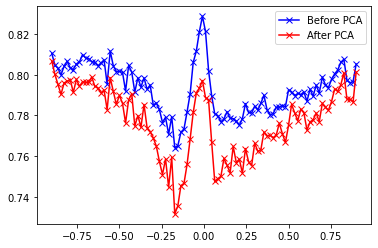

In [18]:
mags=np.linspace(-10,10,100)
measured_corr=np.zeros(100)
rsquared=np.zeros(100)
pcarsquared=np.zeros(100)
mean=[0,0]
cov=[[1,0],[0,1]]
x=np.random.multivariate_normal(mean, cov, 10**5)
toydata=pd.DataFrame(x, columns=['x1','x2'])
toydata['y']=toydata.apply(lambda row: 5*row['x1']+5*row['x2']+np.random.normal(), axis=1)


for index, mag in tqdm(enumerate(mags)):
    toydata['x3']=toydata.apply(lambda row: (row['x1']*row['x2'])+np.random.normal(scale=0.1), axis=1)
    toydata['x4']=toydata.apply(lambda row: (row['x1']/row['x2'])+np.random.normal(scale=0.1)+mag*row['x1'], axis=1)
    
    x_train, x_test, y_train, y_test=train_test_split(toydata[toydata['y']>0][['x3','x4']], toydata[toydata['y']>0]['y'], test_size=0.3, shuffle=True)
    Predictor=RandomForestRegressor().fit(x_train, y_train)
    rsquared[index]=Predictor.score(x_test, y_test)
    
    scaler=StandardScaler()
    scaler.fit(x_train)
    pcax_train=scaler.transform(x_train)
    pcax_test=scaler.transform(x_test)
    
    pca=PCA(0.9999)
    pca.fit(pcax_train)
    pcax_train=pca.transform(pcax_train)
    pcax_test=pca.transform(pcax_test)

    Predictor=RandomForestRegressor().fit(pcax_train, y_train)
    pcarsquared[index]=Predictor.score(pcax_test, y_test)

plt.plot(rhos, rsquared, 'x-', color='blue', label='Before PCA')
plt.plot(rhos, pcarsquared, 'x-', color='red', label='After PCA')
plt.legend()

100it [1:42:23, 61.43s/it]


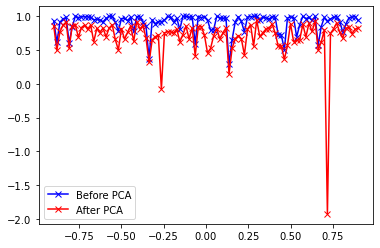

In [24]:
rhos=np.linspace(-0.9,0.9,100)
rsquared=np.zeros(100)
pcarsquared=np.zeros(100)
mean=[0,0]
for index, rho in tqdm(enumerate(rhos)):
    cov=[[1,rho],[rho,1]]
    x=np.random.multivariate_normal(mean, cov, 10**5)
    toydata=pd.DataFrame(x, columns=['x1','x2'])
    toydata['y']=toydata.apply(lambda row: 5*row['x1']+5*row['x2']+1*row['x1']**10+np.random.normal(), axis=1)
    
    x_train, x_test, y_train, y_test=train_test_split(toydata[['x1','x2']], toydata['y'], test_size=0.3, shuffle=True)
    Predictor=RandomForestRegressor().fit(x_train, y_train)
    rsquared[index]=Predictor.score(x_test, y_test)
    
    scaler=StandardScaler()
    scaler.fit(x_train)
    pcax_train=scaler.transform(x_train)
    pcax_test=scaler.transform(x_test)
    
    pca=PCA(0.9999)
    pca.fit(pcax_train)
    pcax_train=pca.transform(pcax_train)
    pcax_test=pca.transform(pcax_test)

    Predictor=RandomForestRegressor().fit(pcax_train, y_train)
    pcarsquared[index]=Predictor.score(pcax_test, y_test)

plt.plot(rhos, rsquared, 'x-', color='blue', label='Before PCA')
plt.plot(rhos, pcarsquared, 'x-', color='red', label='After PCA')
plt.legend()

In [74]:
x=np.random.multivariate_normal(mean, cov, 10**5)
print(x)
toydata=pd.DataFrame(x, columns=['x1','x2'])

[[ 0.57983117  0.15222136]
 [ 1.55678584  1.26617851]
 [-0.63481148 -0.7882648 ]
 ...
 [-2.14871966 -2.03494135]
 [ 0.5557259   0.74399419]
 [ 2.26327385  1.95310465]]


In [75]:
toydata['y']=toydata.apply(lambda row: 5*row['x1']+5*row['x2']+np.random.normal(), axis=1)
toydata.head()

,x1,x2,y
0,0.579831,0.152221,2.826474
1,1.556786,1.266179,13.349690
2,-0.634811,-0.788265,-8.295520
3,0.021738,0.275417,1.440402
4,0.923178,0.721709,7.478713


In [76]:
x_train, x_test, y_train, y_test=train_test_split(toydata[['x1','x2']], toydata['y'], test_size=0.3, shuffle=True)
Predictor=RandomForestRegressor().fit(x_train, y_train)

print(Predictor.score(x_test, y_test))


0.9879826243563596


In [58]:
scaler=StandardScaler()
scaler.fit(x_train)
pcax_train=scaler.transform(x_train)
pcax_test=scaler.transform(x_test)
    
pca=PCA(0.9999)
pca.fit(pcax_train)
pcax_train=pca.transform(pcax_train)
pcax_test=pca.transform(pcax_test)

Predictor=RandomForestRegressor().fit(pcax_train, y_train)

print(Predictor.score(pcax_test, y_test))

0.9097420921644979


In [63]:
Lasso_predictor=Lasso(0.0001,normalize=True).fit(x_train, y_train)
print(Lasso_predictor.score(x_test, y_test))
print(Lasso_predictor.coef_)

0.9987636330097689
[ 5.28470656  1.86058317 -0.          1.82329689  0.6368299   1.16405399
  0.54779842  8.91600525 -6.39501268 -0.13409521]


In [14]:
toydata['x3']=toydata.apply(lambda row: np.exp(row['x1'])*0.9+np.random.normal(scale=0.1), axis=1)
toydata['x4']=toydata.apply(lambda row: (row['x1']**3)*0.8+np.random.normal(scale=0.1), axis=1)
toydata['x5']=toydata.apply(lambda row: np.log(abs(row['x2']))*1.1+np.random.normal(scale=0.1), axis=1)
toydata['x6']=toydata.apply(lambda row: 1./row['x2']*1.2+np.random.normal(scale=0.1), axis=1)
toydata['x7']=toydata.apply(lambda row: (row['x1']*row['x2'])*1.3+np.random.normal(scale=0.1), axis=1)
toydata['x8']=toydata.apply(lambda row: (row['x1']/row['x2'])*0.7+np.random.normal(scale=0.1), axis=1)
toydata['x9']=toydata.apply(lambda row: np.exp(row['x2'])*0.7+np.random.normal(scale=0.1), axis=1)

In [29]:
toydata[['x7', 'x8']].corr()

,x7,x8
x7,1.0000,0.9561
x8,0.9561,1.0000


In [30]:
x_train, x_test, y_train, y_test=train_test_split(toydata[toydata['y']>0][['x7','x8']], toydata[toydata['y']>0]['y'], test_size=0.3, shuffle=True)
Predictor=RandomForestRegressor().fit(x_train, y_train)

print(Predictor.score(x_test, y_test))

0.7761838705194055


In [32]:
Lasso_predictor=Lasso(0.01,normalize=True).fit(x_train, y_train)
Lasso_predictor.score(x_test, y_test)

0.13567621507475025

In [15]:
DataSet=pd.read_parquet("spreads_data_train.par")
DataSet=DataSet.sort_values(by='localtime')
tickers=list(DataSet['symbol'].unique())
FeatureSet=pd.read_csv('data_descriptions.csv')
FeatureSet
staticFeatures=list(FeatureSet[(FeatureSet['Category']=='Static') & ((FeatureSet['Type']=='float64') | (FeatureSet['Type']=='int64'))]['Column'])
TandQFeatures=list(FeatureSet[(FeatureSet['Category']=='Trade') | (FeatureSet['Category']=='Quote')]['Column'])
allNumericalFeatures=staticFeatures+TandQFeatures

In [16]:
staticFeatures

['volatility',
 'avg_daily_volume',
 'avg_daily_notional',
 'median_daily_volume',
 'median_daily_notional',
 'mean_width',
 'median_width',
 'median_nbbo_size',
 'opening_price',
 'closing_price']

In [17]:
DataSet=DataSet.rename_axis("ordinal_times").reset_index()
DataSet.head()

,ordinal_times,localtime,symbol,bid,ask,bidsize,asksize,mid,spread,open,...,median_daily_volume,median_daily_notional,mean_width,median_width,median_nbbo_size,opening_price,closing_price,symbol_type,fut_spread,date
0,0,2021-01-04 14:30:00+00:00,CVS,68.56,68.67,205,1,68.615,0.11,68.74,...,5713092.0,404084096.0,0.015603,0.01,642.5,67.70,68.30,Common Stock,0.06,2021-01-04
1,0,2021-01-04 14:30:00+00:00,BKI,88.71,89.05,17,452,88.880,0.34,88.93,...,588347.0,52530742.0,0.059210,0.05,398.0,88.46,88.35,Common Stock,0.30,2021-01-04
2,0,2021-01-04 14:30:00+00:00,BEN,24.92,24.96,160,1300,24.940,0.04,25.00,...,2853712.0,67875047.0,0.010363,0.01,3059.5,24.70,24.99,Common Stock,0.01,2021-01-04
3,0,2021-01-04 14:30:00+00:00,VOT,212.19,212.42,200,300,212.305,0.23,212.97,...,158883.0,32641143.0,0.123496,0.11,300.0,211.78,212.07,ETP,0.23,2021-01-04
4,0,2021-01-04 14:30:00+00:00,OTEX,45.46,45.50,300,200,45.480,0.04,45.90,...,315591.0,14290142.0,0.024247,0.02,600.5,45.48,45.46,Common Stock,0.03,2021-01-04


In [18]:
DataSet['normalized_spread']=DataSet.apply(lambda row: normalizeSpread(row['spread'],row['ask']), axis=1)
DataSet['normalized_fut_spread']=DataSet.apply(lambda row: normalizeSpread(row['fut_spread'],row['ask']), axis=1)
DataSet['recip_ordinal_times']=DataSet.apply(lambda row: 1./(1+row['ordinal_times']), axis=1)
#DataSet['time_of_day']=DataSet['localtime'].dt.time

In [14]:
print(DataSet[DataSet.isna().any(axis=1)==True]['symbol'].unique())
print(DataSet[(DataSet.isna().any(axis=1)==True) & (DataSet['numEvents']>0)]['symbol'].unique())

['CTRA' 'AFRM' 'PLTK' 'STLA' 'AXON' 'NOK' 'CLVT' 'AEE' 'CCJ' 'HPQ' 'MPC'
 'TFII' 'PCOR' 'ARGX' 'SOFI' 'BIIB' 'MNDY' 'IWV' 'TTE' 'BZ' 'DFAC' 'GRUB'
 'YMM' 'DIDI' 'GIB' 'QGEN' 'LCID' 'HOOD']
['CTRA' 'AFRM' 'PLTK' 'STLA' 'AXON' 'CLVT' 'PCOR' 'SOFI' 'MNDY' 'TTE' 'BZ'
 'DFAC' 'YMM' 'DIDI' 'LCID' 'HOOD']


In [19]:
DataSet=DataSet[DataSet['numEvents']>0]
DataSet=DataSet[(DataSet['normalized_spread']>0) & (DataSet['normalized_fut_spread']>0)]

In [20]:
DataSet.loc[DataSet['symbol']=='CTRA','symbol_type']='Common Stock'
DataSet[DataSet['symbol']=='CTRA']
DataSet=DataSet.dropna()

Text(0, 0.5, 'GS open price ($)')

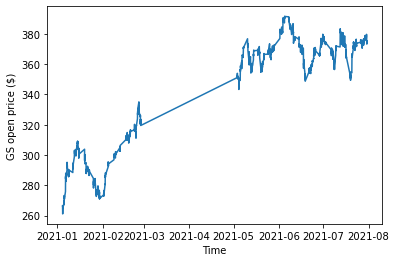

In [17]:
plt.plot(DataSet[DataSet['symbol']=='GS']['localtime'], DataSet[DataSet['symbol']=='GS']['close'])
plt.xlabel('Time')
plt.ylabel('GS open price ($)')

Text(0.5, 1.0, 'TTD')

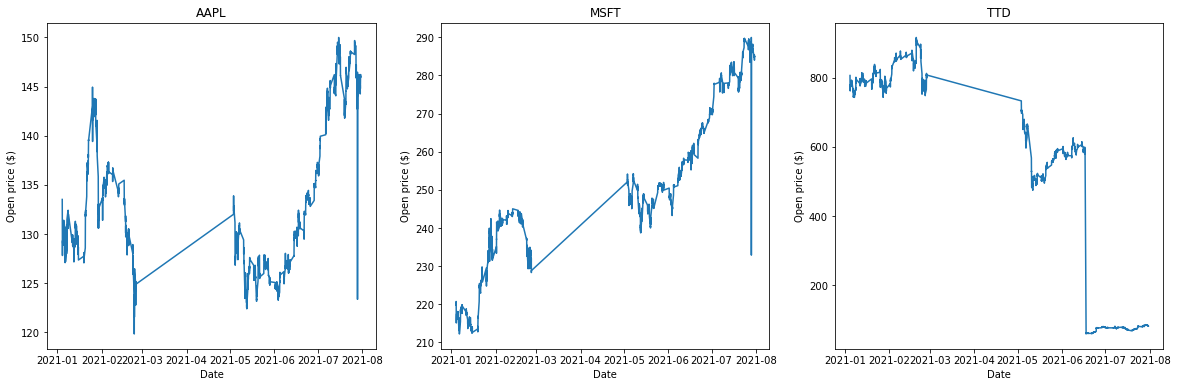

In [18]:
fig, axs=plt.subplots(1,3)
fig.set_size_inches(20,6)
axs[0].plot(DataSet[DataSet['symbol']=='AAPL']['localtime'], DataSet[DataSet['symbol']=='AAPL']['open'])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Open price ($)')
axs[0].set_title('AAPL')

axs[1].plot(DataSet[DataSet['symbol']=='MSFT']['localtime'], DataSet[DataSet['symbol']=='MSFT']['close'])
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Open price ($)')
axs[1].set_title('MSFT')

axs[2].plot(DataSet[DataSet['symbol']=='TTD']['localtime'], DataSet[DataSet['symbol']=='TTD']['open'])
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Open price ($)')
axs[2].set_title('TTD')

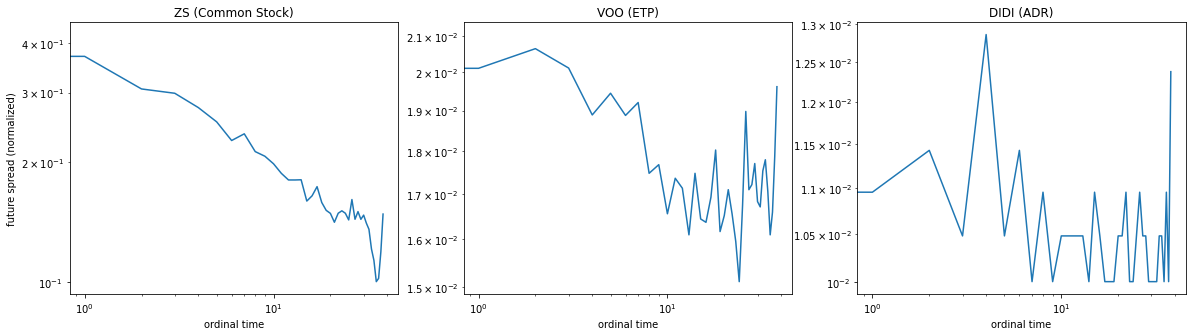

In [19]:
ZS=DataSet[DataSet['symbol']=='ZS'][['fut_spread', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
VOO=DataSet[DataSet['symbol']=='VOO'][['fut_spread', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
DIDI=DataSet[DataSet['symbol']=='DIDI'][['fut_spread', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
fig, axs=plt.subplots(1,3, sharex=True)

fig.set_size_inches(20,5)

axs[0].plot(ZS['fut_spread'])
axs[0].set_xlabel('ordinal time')
axs[0].set_ylabel('future spread (normalized)')
axs[0].set_title('ZS (Common Stock)')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].plot(VOO['fut_spread'])
axs[1].set_xlabel('ordinal time')
axs[1].set_title('VOO (ETP)')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[2].plot(DIDI['fut_spread'])
axs[2].set_xlabel('ordinal time')
axs[2].set_title('DIDI (ADR)')
axs[2].set_xscale('log')
axs[2].set_yscale('log')

plt.show()

In [20]:
start_date=min(DataSet['date'])
end_date=max(DataSet['date'])
missing_dates=pd.date_range(start=start_date, end=end_date, freq='B').difference(DataSet['date'])
print(start_date)
print(end_date)
print(missing_dates)

2021-01-04
2021-07-30
DatetimeIndex(['2021-01-18', '2021-02-10', '2021-02-11', '2021-02-15',
               '2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04',
               '2021-03-05', '2021-03-08', '2021-03-09', '2021-03-10',
               '2021-03-11', '2021-03-12', '2021-03-15', '2021-03-16',
               '2021-03-17', '2021-03-18', '2021-03-19', '2021-03-22',
               '2021-03-23', '2021-03-24', '2021-03-25', '2021-03-26',
               '2021-03-29', '2021-03-30', '2021-03-31', '2021-04-01',
               '2021-04-02', '2021-04-05', '2021-04-06', '2021-04-07',
               '2021-04-08', '2021-04-09', '2021-04-12', '2021-04-13',
               '2021-04-14', '2021-04-15', '2021-04-16', '2021-04-19',
               '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23',
               '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29',
               '2021-04-30', '2021-05-31', '2021-07-05'],
              dtype='datetime64[ns]', freq=None)


Text(0, 0.5, 'Frequency')

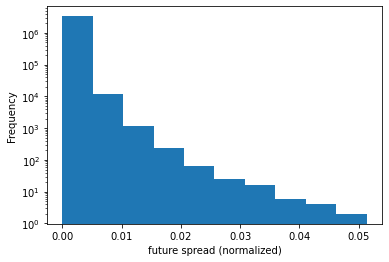

In [21]:
plt.hist(DataSet['normalized_fut_spread'])
plt.yscale('log')
plt.xlabel('future spread (normalized)')
plt.ylabel('Frequency')

(0.0, 0.1)

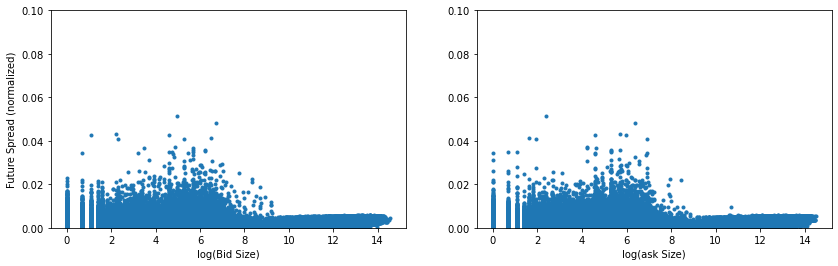

In [22]:
fig, axs=plt.subplots(1,2)
fig.set_size_inches(14,4)
axs[0].plot(np.log(DataSet['bidsize']), DataSet['normalized_fut_spread'], ls='none', Marker='.', MarkerSize=6)
axs[0].set_xlabel('log(Bid Size)')
axs[0].set_ylabel('Future Spread (normalized)')
axs[0].set_ylim(0,0.1)

axs[1].plot(np.log(DataSet['asksize']), DataSet['normalized_fut_spread'], ls='none', Marker='.', MarkerSize=6)
axs[1].set_xlabel('log(ask Size)')
axs[1].set_ylim(0,0.1)

In [23]:
DataSet.corr()['fut_spread']

ordinal_times           -0.066620
bid                      0.702829
ask                      0.703635
bidsize                 -0.036163
asksize                 -0.036752
mid                      0.703232
spread                   0.860707
open                     0.703193
high                     0.704024
low                      0.702686
close                    0.703228
volume                  -0.046998
numEvents               -0.034903
notional_volume          0.006574
volatility               0.019232
avg_daily_volume        -0.074347
avg_daily_notional       0.002051
median_daily_volume     -0.079782
median_daily_notional    0.001923
mean_width               0.023923
median_width             0.859819
median_nbbo_size        -0.039676
opening_price            0.704258
closing_price            0.703705
fut_spread               1.000000
normalized_spread        0.297874
normalized_fut_spread    0.409448
recip_ordinal_times      0.076929
Name: fut_spread, dtype: float64

In [24]:
DataSet[staticFeatures+['ordinal_times']+['fut_spread']+['recip_ordinal_times']].corr()

,volatility,avg_daily_volume,avg_daily_notional,median_daily_volume,median_daily_notional,mean_width,median_width,median_nbbo_size,opening_price,closing_price,ordinal_times,fut_spread,recip_ordinal_times
volatility,1.000000,0.247031,0.072569,0.202399,0.044974,0.003184,0.020348,0.007606,-0.026140,-0.026626,0.001073,0.019232,-0.001092
avg_daily_volume,0.247031,1.000000,0.457935,0.977716,0.422859,0.016321,-0.078667,0.258526,-0.097359,-0.097534,0.000577,-0.074347,-0.000525
avg_daily_notional,0.072569,0.457935,1.000000,0.483875,0.995043,0.006121,0.005801,-0.001882,0.209113,0.209190,0.000059,0.002051,0.000029
median_daily_volume,0.202399,0.977716,0.483875,1.000000,0.459740,0.020033,-0.084416,0.270495,-0.101848,-0.102000,0.000570,-0.079782,-0.000487
median_daily_notional,0.044974,0.422859,0.995043,0.459740,1.000000,0.006807,0.005647,-0.001317,0.210238,0.210363,0.000039,0.001923,0.000056
mean_width,0.003184,0.016321,0.006121,0.020033,0.006807,1.000000,0.024536,-0.001755,0.017015,0.017086,0.000027,0.023923,-0.000022
median_width,0.020348,-0.078667,0.005801,-0.084416,0.005647,0.024536,1.000000,-0.041984,0.798089,0.797099,0.000474,0.859819,-0.000414
median_nbbo_size,0.007606,0.258526,-0.001882,0.270495,-0.001317,-0.001755,-0.041984,1.000000,-0.082501,-0.082550,0.000281,-0.039676,-0.000284
opening_price,-0.026140,-0.097359,0.209113,-0.101848,0.210238,0.017015,0.798089,-0.082501,1.000000,0.999802,0.000294,0.704258,-0.000239
closing_price,-0.026626,-0.097534,0.209190,-0.102000,0.210363,0.017086,0.797099,-0.082550,0.999802,1.000000,0.000292,0.703705,-0.000238


In [25]:
DataSet[DataSet['symbol']=='AAPL'][staticFeatures+['ordinal_times']+['fut_spread']+['recip_ordinal_times']].corr()['fut_spread']

volatility               0.220316
avg_daily_volume         0.217390
avg_daily_notional       0.214133
median_daily_volume      0.208773
median_daily_notional    0.210524
mean_width               0.272402
median_width             0.188796
median_nbbo_size        -0.191222
opening_price            0.072970
closing_price            0.068884
ordinal_times           -0.004614
fut_spread               1.000000
recip_ordinal_times      0.107043
Name: fut_spread, dtype: float64

In [26]:
DataSet[DataSet['symbol']=='IAC'][staticFeatures+['ordinal_times']+['fut_spread']+['recip_ordinal_times']].corr()['fut_spread']

volatility              -0.223709
avg_daily_volume        -0.250826
avg_daily_notional       0.020823
median_daily_volume     -0.255034
median_daily_notional    0.030584
mean_width               0.421930
median_width             0.430318
median_nbbo_size        -0.272718
opening_price            0.404124
closing_price            0.397041
ordinal_times           -0.432351
fut_spread               1.000000
recip_ordinal_times      0.506825
Name: fut_spread, dtype: float64

Text(0.5, 0, 'Ordinal Times')

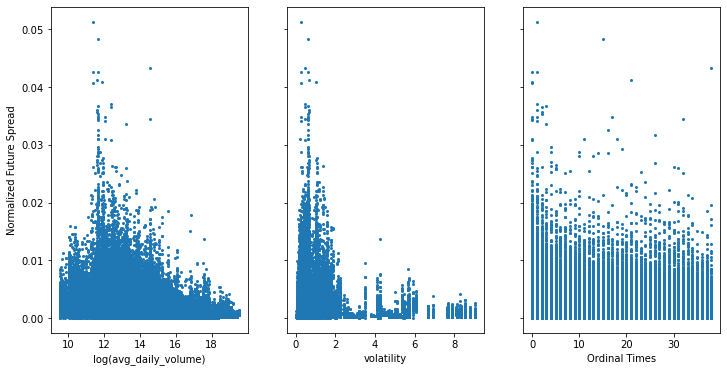

In [27]:
fig, axs=plt.subplots(1,3, sharey=True)
fig.set_size_inches(12,6)
axs[0].plot(np.log(DataSet['avg_daily_volume']), DataSet['normalized_fut_spread'],ls='none', Marker='.',MarkerSize=4)
axs[0].set_ylabel('Normalized Future Spread')
axs[0].set_xlabel('log(avg_daily_volume)')

axs[1].plot(DataSet['volatility'], DataSet['normalized_fut_spread'],ls='none', Marker='.',MarkerSize=4)
axs[1].set_xlabel('volatility')

axs[2].plot(DataSet['ordinal_times'], DataSet['normalized_fut_spread'], ls='none', Marker='.', MarkerSize=4)
axs[2].set_xlabel('Ordinal Times')

In [28]:
avg_by_ticker=DataSet[['symbol','avg_daily_volume','volatility']].groupby('symbol').mean()
avg_by_ticker.head()

,avg_daily_volume,volatility
symbol,,
A,1.190817e+06,0.185294
AAL,3.960736e+07,0.449055
AAP,7.592952e+05,0.251260
AAPL,7.317024e+07,0.273495
ABB,1.424474e+06,0.233069


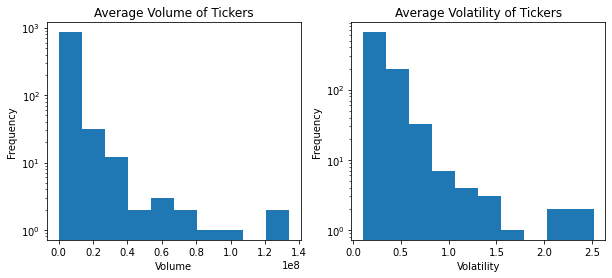

In [29]:
fig, axs=plt.subplots(1,2)
fig.set_size_inches(10,4)
axs[0].set_title('Average Volume of Tickers')
axs[0].hist(avg_by_ticker['avg_daily_volume'])
axs[0].set_yscale('log')
axs[0].set_xlabel('Volume')
axs[0].set_ylabel('Frequency')
axs[1].hist(avg_by_ticker['volatility'])
axs[1].set_xlabel('Volatility')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Average Volatility of Tickers')
axs[1].set_yscale('log')
plt.savefig('vol_vol_freq_plot_per_ticker.pdf')

In [30]:
print(DataSet[(DataSet['volatility']>1.5) & (DataSet['avg_daily_volume']>10**7) & 
              (DataSet['date']>=datetime.date(2021,6,14)) & (DataSet['date']<=datetime.date(2021,6,18))
             & (DataSet['symbol_type']=='Common Stock')]['symbol'].unique())

print(DataSet[(DataSet['volatility']>1.5) & (DataSet['avg_daily_volume']>10**6) & (DataSet['avg_daily_volume']<10**7)
              & (DataSet['date']>=datetime.date(2021,6,14)) & (DataSet['date']<=datetime.date(2021,6,18))
             & (DataSet['symbol_type']=='Common Stock')]['symbol'].unique())

print(DataSet[(DataSet['volatility']>1.5) & (DataSet['avg_daily_volume']<10**6)
              & (DataSet['date']>=datetime.date(2021,6,14)) & (DataSet['date']<=datetime.date(2021,6,18))
             & (DataSet['symbol_type']=='Common Stock')]['symbol'].unique())


print(DataSet[(DataSet['volatility']<1.5) & (DataSet['volatility']>.5) & (DataSet['avg_daily_volume']>10**7)
              & (DataSet['date']>=datetime.date(2021,6,14)) & (DataSet['date']<=datetime.date(2021,6,18))
             & (DataSet['symbol_type']=='Common Stock')]['symbol'].unique())

print(DataSet[(DataSet['volatility']<1.5) & (DataSet['volatility']>.5) & (DataSet['avg_daily_volume']>10**6) & (DataSet['avg_daily_volume']<10**7)
              & (DataSet['date']>=datetime.date(2021,6,14)) & (DataSet['date']<=datetime.date(2021,6,18))
             & (DataSet['symbol_type']=='Common Stock')]['symbol'].unique())

print(DataSet[(DataSet['volatility']<1.5) & (DataSet['volatility']>.5)& (DataSet['avg_daily_volume']<10**6)
              & (DataSet['date']>=datetime.date(2021,6,14)) & (DataSet['date']<=datetime.date(2021,6,18))
             & (DataSet['symbol_type']=='Common Stock')]['symbol'].unique())


print(DataSet[(DataSet['volatility']<.5) & (DataSet['avg_daily_volume']>10**7)
              & (DataSet['date']>=datetime.date(2021,6,14)) & (DataSet['date']<=datetime.date(2021,6,18))
             & (DataSet['symbol_type']=='Common Stock')]['symbol'].unique())
print(DataSet[(DataSet['volatility']<.5) & (DataSet['avg_daily_volume']>10**6) & (DataSet['avg_daily_volume']<10**7)
              & (DataSet['date']>=datetime.date(2021,6,14)) & (DataSet['date']<=datetime.date(2021,6,18))
             & (DataSet['symbol_type']=='Common Stock')]['symbol'].unique())
print(DataSet[(DataSet['volatility']<.5) & (DataSet['avg_daily_volume']<10**6)
              & (DataSet['date']>=datetime.date(2021,6,14)) & (DataSet['date']<=datetime.date(2021,6,18))
             & (DataSet['symbol_type']=='Common Stock')]['symbol'].unique())

['AMC']
['GME' 'CP']
['IAC']
['DVN' 'RBLX' 'OPEN' 'CLF' 'DKNG' 'PTON' 'PLUG' 'F' 'MRO']
['CCJ' 'BIIB' 'ENPH' 'DASH' 'CVNA' 'WDC' 'CLVT' 'TECK' 'SOFI' 'RUN' 'ETSY'
 'PCOR' 'BILL' 'UPST' 'NUE' 'RNG' 'ROKU' 'EXAS' 'SNOW' 'TTD' 'NVAX' 'NLOK'
 'DDOG' 'AFRM' 'PENN' 'NET' 'MRNA' 'W' 'STX' 'CZR' 'DOCU' 'COIN' 'ASAN'
 'FTCH' 'PATH' 'GH' 'AMAT' 'WIX' 'XP' 'LYV' 'BLDR']
['AXON' 'IAC' 'SEDG' 'TXG' 'BAP' 'APP' 'WIX' 'GH' 'AFG' 'NTRA' 'LSPD' 'RH'
 'MDB' 'ALB']
['MSFT' 'KMI' 'SNAP' 'VIAC' 'PLTR' 'VZ' 'PFE' 'PCG' 'AAL' 'FCX' 'C' 'T'
 'GOLD' 'UAL' 'INTC' 'XOM' 'F' 'WFC' 'BA' 'SIRI' 'AMD' 'KO' 'DISCA' 'HBAN'
 'SLB' 'UBER' 'CSCO' 'CCL' 'CMCSA' 'PINS' 'MU' 'GM' 'TSLA' 'BAC' 'FB'
 'OXY' 'AAPL' 'MRO' 'GE' 'ABNB']
['GS' 'ATVI' 'BDX' 'LUMN' 'LOW' 'NUAN' 'HES' 'QCOM' 'CMA' 'BNS' 'MFC'
 'TJX' 'CNC' 'WSM' 'DRI' 'EOG' 'VFC' 'PHM' 'UBS' 'XEL' 'HWM' 'HON' 'FITB'
 'PPL' 'ADI' 'AON' 'RF' 'WMT' 'APH' 'MRK' 'INTU' 'ACN' 'AMAT' 'A' 'EIX'
 'ESTC' 'PNC' 'LYFT' 'SWKS' 'HPE' 'CI' 'CF' 'FE' 'VLO' 'MCD' 'MET' 'PG'
 'VTRS' 'TF

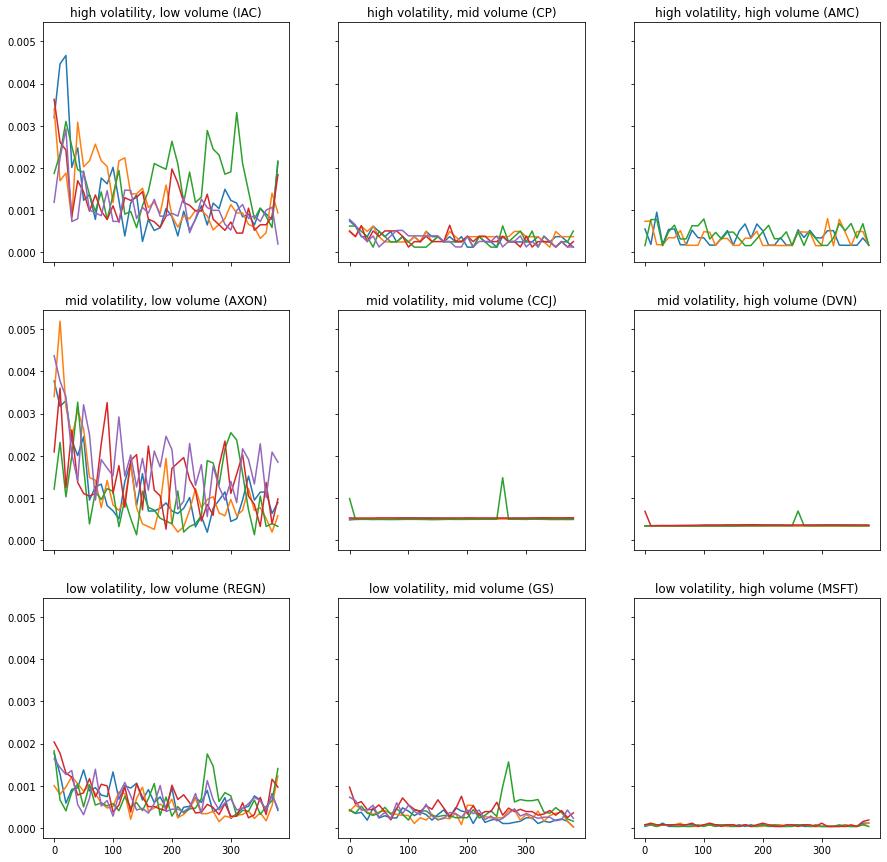

In [31]:
fig, ax=plt.subplots(3,3, sharex=True, sharey=True)
fig.set_size_inches(15,15)

minutes_since_open=10.*DataSet['ordinal_times'].unique()
dates_to_plot=[datetime.date(2021,6,14),datetime.date(2021,6,15),datetime.date(2021,6,16),datetime.date(2021,6,17),datetime.date(2021,6,18)]

ticker_of_int='IAC'
for day in dates_to_plot:
    if len(minutes_since_open)==len(DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread']):
        ax[0,0].plot(minutes_since_open, DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread'])
ax[0,0].set_title('high volatility, low volume (IAC)')

ticker_of_int='CP'
for day in dates_to_plot:
    if len(minutes_since_open)==len(DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread']):
        ax[0,1].plot(minutes_since_open, DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread'])
ax[0,1].set_title('high volatility, mid volume (CP)')

ticker_of_int='AMC'
for day in dates_to_plot:
    if len(minutes_since_open)==len(DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread']):
        ax[0,2].plot(minutes_since_open, DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread'])
ax[0,2].set_title('high volatility, high volume (AMC)')

ticker_of_int='AXON'
for day in dates_to_plot:
    if len(minutes_since_open)==len(DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread']):
        ax[1,0].plot(minutes_since_open, DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread'])
ax[1,0].set_title('mid volatility, low volume (AXON)')

ticker_of_int='CCJ'
for day in dates_to_plot:
    if len(minutes_since_open)==len(DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread']):
        ax[1,1].plot(minutes_since_open, DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread'])
ax[1,1].set_title('mid volatility, mid volume (CCJ)')

ticker_of_int='DVN'
for day in dates_to_plot:
    if len(minutes_since_open)==len(DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread']):
        ax[1,2].plot(minutes_since_open, DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread'])
ax[1,2].set_title('mid volatility, high volume (DVN)')

ticker_of_int='REGN'
for day in dates_to_plot:
    if len(minutes_since_open)==len(DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread']):
        ax[2,0].plot(minutes_since_open, DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread'])
ax[2,0].set_title('low volatility, low volume (REGN)')

ticker_of_int='GS'
for day in dates_to_plot:
    if len(minutes_since_open)==len(DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread']):
        ax[2,1].plot(minutes_since_open, DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread'])
ax[2,1].set_title('low volatility, mid volume (GS)')

ticker_of_int='MSFT'
for day in dates_to_plot:
    if len(minutes_since_open)==len(DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread']):
        ax[2,2].plot(minutes_since_open, DataSet[(DataSet['symbol']==ticker_of_int) & (DataSet['date']==day)]['normalized_fut_spread'])
ax[2,2].set_title('low volatility, high volume (MSFT)')

plt.savefig('Volatility_vs_Volume.pdf')

In [32]:
avg_by_symbol_type=DataSet[['symbol_type','avg_daily_volume','volatility','fut_spread']].groupby('symbol_type').mean()
std_by_symbol_type=DataSet[['symbol_type','avg_daily_volume','volatility','fut_spread']].groupby('symbol_type').std()
avg_and_std_by_symbol_type=pd.merge(avg_by_symbol_type, std_by_symbol_type, on='symbol_type', suffixes=('_avg', '_std'))
avg_and_std_by_symbol_type

,avg_daily_volume_avg,volatility_avg,fut_spread_avg,avg_daily_volume_std,volatility_std,fut_spread_std
symbol_type,,,,,,
ADR,6.729040e+06,0.385499,0.063461,1.527040e+07,0.303837,0.189559
Common Stock,3.479819e+06,0.326581,0.166805,9.196941e+06,0.325911,0.610921
ETP,4.788620e+06,0.162414,0.029905,9.098183e+06,0.086231,0.045162
Ltd Part,2.403466e+05,0.149166,0.041311,4.740135e+04,0.033897,0.019937
MLP,5.223539e+06,0.261230,0.035309,6.416160e+06,0.076364,0.051603
NY Reg Shrs,1.811098e+06,0.360900,0.117271,1.538434e+06,0.097086,0.204124
REIT,1.783624e+06,0.262028,0.073727,2.177627e+06,0.338662,0.138918
Tracking Stk,6.075667e+05,0.265130,0.051341,1.210284e+05,0.060252,0.039726


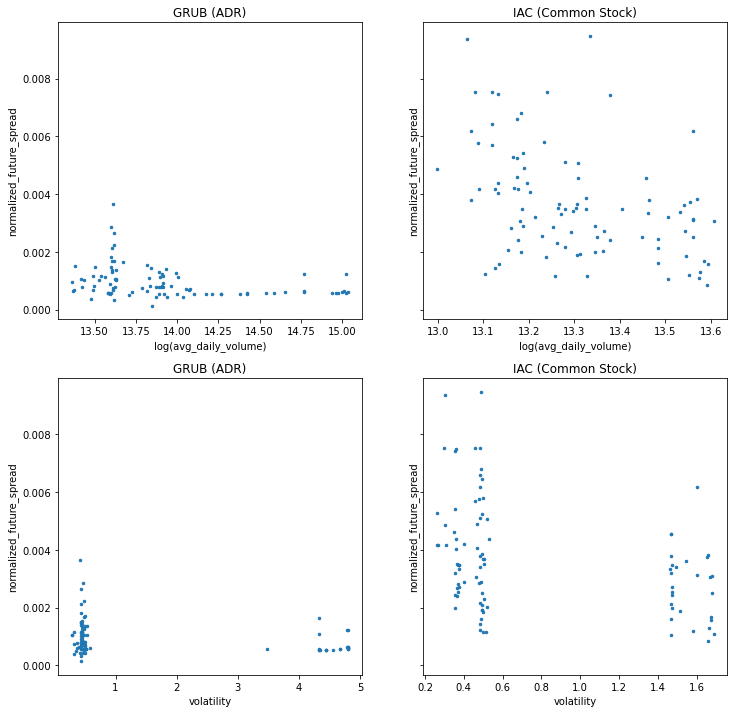

In [33]:
fig, axs=plt.subplots(2,2, sharey=True)
fig.set_size_inches(12,12)
axs[0,0].plot(np.log(DataSet[(DataSet['symbol']=='GRUB') & (DataSet['ordinal_times']==0)]['avg_daily_volume']), DataSet[(DataSet['symbol']=='GRUB')  & (DataSet['ordinal_times']==0)]['normalized_fut_spread'],ls="none", Marker='.',ms=5)
axs[0,0].set_xlabel('log(avg_daily_volume)')
axs[0,0].set_ylabel('normalized_future_spread')
axs[0,0].set_title('GRUB (ADR)')

axs[0,1].plot(np.log(DataSet[(DataSet['symbol']=='IAC') & (DataSet['ordinal_times']==0)]['avg_daily_volume']), DataSet[(DataSet['symbol']=='IAC') & (DataSet['ordinal_times']==0)]['normalized_fut_spread'],ls="none", Marker='.',ms=5)
axs[0,1].set_xlabel('log(avg_daily_volume)')
axs[0,1].set_ylabel('normalized_future_spread')
axs[0,1].set_title('IAC (Common Stock)')

axs[1,0].plot(DataSet[(DataSet['symbol']=='GRUB') & (DataSet['ordinal_times']==0)]['volatility'], DataSet[(DataSet['symbol']=='GRUB') & (DataSet['ordinal_times']==0)]['normalized_fut_spread'],ls="none", Marker='.',ms=5)
axs[1,0].set_xlabel('volatility')
axs[1,0].set_ylabel('normalized_future_spread')
axs[1,0].set_title('GRUB (ADR)')

axs[1,1].plot(DataSet[(DataSet['symbol']=='IAC') & (DataSet['ordinal_times']==0)]['volatility'], DataSet[(DataSet['symbol']=='IAC') & (DataSet['ordinal_times']==0)]['normalized_fut_spread'],ls="none", Marker='.',ms=5)
axs[1,1].set_xlabel('volatility')
axs[1,1].set_ylabel('normalized_future_spread')
axs[1,1].set_title('IAC (Common Stock)')
plt.show()

In [219]:
x_train, x_test, y_train, y_test=splitData(DataSet[DataSet['symbol']=='ZS'], staticFeatures+['recip_ordinal_times'], 'fut_spread', 0.1)

Predictor=Ridge(alpha=0.00001,normalize=True).fit(x_train, y_train)

print(Predictor.coef_)

print(Predictor.score(x_test, y_test))

y_test_pred=Predictor.predict(x_test)

error=(y_test_pred-y_test)**2
RMSE=np.sqrt(error.sum()/len(y_test))

print(RMSE/DataSet[(DataSet['symbol']=='ZS')]['fut_spread'].std())

plt.plot(y_test, y_test_pred,ls='none', MarkerSize=4, Marker='.')

plt.xlim(0,3)
plt.ylim(0,3)

KeyError: "['recip_ordinal_times'] not in index"

In [69]:
alphas=np.logspace(-8.,-3.,num=10, endpoint=True)
symbol_type='Common Stock'
target='fut_spread'
testsize=0.25
staticFeatures_lasso=staticFeatures+['ordinal_times']+['exp_ordinal_times']

coefficient_tracker=np.zeros((len(staticFeatures_lasso), len(alphas)))

train_error=np.zeros(len(alphas))
test_error=np.zeros(len(alphas))
train_rsquared=np.zeros(len(alphas))
test_rsquared=np.zeros(len(alphas))


for index, alpha in tqdm(enumerate(alphas)):
    (Lasso_fit, x_train, x_test, y_train, y_test)=LassoFitter(DataSet,symbol_type, staticFeatures_lasso, target, testsize, alpha)
    y_train_pred=Lasso_fit.predict(x_train)
    y_test_pred=Lasso_fit.predict(x_test)
    
    num_indep_var=np.sum((Lasso_fit.coef_)>0)
    
    train_error[index]=np.sqrt(metrics.mean_squared_error(y_train_pred, y_train))/(DataSet[DataSet['symbol_type']=='Common Stock']['fut_spread'].std())
    test_error[index]=np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))/(DataSet[DataSet['symbol_type']=='Common Stock']['fut_spread'].std())
    
    rsquared=Lasso_fit.score(x_train, y_train)
    n=np.shape(x_train)[0]
    train_rsquared[index]=1-(1-rsquared)*(n-1)/(n-num_indep_var-1)
    
    rsquared=Lasso_fit.score(x_test, y_test)
    n=np.shape(x_test)[0]
    test_rsquared[index]=1-(1-rsquared)*(n-1)/(n-num_indep_var-1)
    
    
    coefficients=Lasso_fit.coef_
    coefficient_tracker[:, index]=coefficients

                                                                                   

0it [00:00, ?it/s]


KeyError: "['exp_ordinal_times'] not in index"

In [ ]:
coef_names=x_train.columns

fig, axs=plt.subplots(1,3)

for index, name in enumerate(coef_names):
    axs[0].plot(alphas, coefficient_tracker[index,:], label=coef_names[index])
fig.set_size_inches(25,6)  
axs[0].legend()
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('Regression Coefficient')

axs[0].set_yscale('log')
axs[0].set_xscale('log')

axs[1].plot(alphas, train_rsquared, label='train')
axs[1].plot(alphas, test_rsquared, label='test')
axs[1].legend()

axs[1].set_xlabel('alpha')
axs[1].set_ylabel('adjusted coefficient of determination')
axs[1].set_xscale('log')

axs[2].plot(alphas, train_error, label='train')
axs[2].plot(alphas, test_error, label='test')
axs[2].legend()

axs[2].set_xlabel('alpha')
axs[2].set_ylabel('RMSE normalized by target mean')
axs[2].set_xscale('log')



plt.show()

In [ ]:
alphas=np.logspace(-8.,-3.,num=10, endpoint=True)
symbol_type='Common Stock'
target='fut_spread'
testsize=0.25
staticFeatures_ridge=staticFeatures+['ordinal_times']+['exp_ordinal_times']

coefficient_tracker=np.zeros((len(staticFeatures_ridge), len(alphas)))
train_error=np.zeros(len(alphas))
test_error=np.zeros(len(alphas))
train_rsquared=np.zeros(len(alphas))
test_rsquared=np.zeros(len(alphas))


for index, alpha in tqdm(enumerate(alphas)):
    (Ridge_fit, x_train, x_test, y_train, y_test)=RidgeFitter(DataSet,symbol_type, staticFeatures_ridge, target, testsize, alpha)
    y_train_pred=Ridge_fit.predict(x_train)
    y_test_pred=Ridge_fit.predict(x_test)
    
    train_error[index]=np.sqrt(metrics.mean_squared_error(y_train_pred, y_train))/(DataSet[DataSet['symbol_type']=='Common Stock']['fut_spread'].std())
    test_error[index]=np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))/(DataSet[DataSet['symbol_type']=='Common Stock']['fut_spread'].std())

    rsquared=Ridge_fit.score(x_train, y_train)
    n=np.shape(x_train)[0]
    train_rsquared[index]=1-(1-rsquared)*(n-1)/(n-num_indep_var-1)
    
    rsquared=Ridge_fit.score(x_test, y_test)
    n=np.shape(x_test)[0]
    test_rsquared[index]=1-(1-rsquared)*(n-1)/(n-num_indep_var-1)

    coefficients=Ridge_fit.coef_
    coefficient_tracker[:, index]=coefficients

In [ ]:
coef_names=x_train.columns

fig, axs=plt.subplots(1,3)

for index, name in enumerate(coef_names):
    axs[0].plot(alphas, coefficient_tracker[index,:], label=coef_names[index])
fig.set_size_inches(30,12)  
axs[0].legend()
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('Regression Coefficient')

axs[0].set_yscale('log')
axs[0].set_xscale('log')

axs[1].plot(alphas, train_rsquared, label='train')
axs[1].plot(alphas, test_rsquared, label='test')
axs[1].legend()

axs[1].set_xlabel('alpha')
axs[1].set_ylabel('adjusted coefficient of determination')
axs[1].set_xscale('log')

axs[2].plot(alphas, train_error, label='train')
axs[2].plot(alphas, test_error, label='test')
axs[2].legend()

axs[2].set_xlabel('alpha')
axs[2].set_ylabel('RMSE normalized by target mean')
axs[2].set_xscale('log')



plt.show()

In [ ]:
alphas=np.logspace(-6.,-1.,num=10, endpoint=True)
symbol_type='Common Stock'
target='fut_spread'
testsize=0.25
allNumericalFeatures_lasso=allNumericalFeatures+['ordinal_times']+['exp_ordinal_times']

coefficient_tracker=np.zeros((len(allNumericalFeatures_lasso), len(alphas)))

train_error=np.zeros(len(alphas))
test_error=np.zeros(len(alphas))
train_rsquared=np.zeros(len(alphas))
test_rsquared=np.zeros(len(alphas))


for index, alpha in tqdm(enumerate(alphas)):
    (Lasso_fit, x_train, x_test, y_train, y_test)=LassoFitter(DataSet,symbol_type, allNumericalFeatures_lasso, target, testsize, alpha)
    y_train_pred=Lasso_fit.predict(x_train)
    y_test_pred=Lasso_fit.predict(x_test)
    
    num_indep_var=np.sum((Lasso_fit.coef_)>0)
    
    train_error[index]=np.sqrt(metrics.mean_squared_error(y_train_pred, y_train))/(DataSet[DataSet['symbol_type']=='Common Stock']['fut_spread'].std())
    test_error[index]=np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))/(DataSet[DataSet['symbol_type']=='Common Stock']['fut_spread'].std())
    
    rsquared=Lasso_fit.score(x_train, y_train)
    n=np.shape(x_train)[0]
    train_rsquared[index]=1-(1-rsquared)*(n-1)/(n-num_indep_var-1)
    
    rsquared=Lasso_fit.score(x_test, y_test)
    n=np.shape(x_test)[0]
    test_rsquared[index]=1-(1-rsquared)*(n-1)/(n-num_indep_var-1)
    
    
    coefficients=Lasso_fit.coef_
    coefficient_tracker[:, index]=coefficients

                                                                                 

In [ ]:
coef_names=x_train.columns

fig, axs=plt.subplots(1,3)

for index, name in enumerate(coef_names):
    axs[0].plot(alphas, coefficient_tracker[index,:], label=coef_names[index])
fig.set_size_inches(30,12)  
axs[0].legend()
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('Regression Coefficient')

axs[0].set_yscale('log')
axs[0].set_xscale('log')

axs[1].plot(alphas, train_rsquared, label='train')
axs[1].plot(alphas, test_rsquared, label='test')
axs[1].legend()

axs[1].set_xlabel('alpha')
axs[1].set_ylabel('adjusted coefficient of determination')
axs[1].set_xscale('log')

axs[2].plot(alphas, train_error, label='train')
axs[2].plot(alphas, test_error, label='test')
axs[2].legend()

axs[2].set_xlabel('alpha')
axs[2].set_ylabel('RMSE normalized by target mean')
axs[2].set_xscale('log')



plt.show()

In [ ]:
alphas=np.logspace(-8.,-3.,num=10, endpoint=True)
symbol_type='Common Stock'
target='fut_spread'
testsize=0.25
allNumericalFeatures_ridge=allNumericalFeatures+['ordinal_times']+['exp_ordinal_times']

coefficient_tracker=np.zeros((len(allNumericalFeatures_ridge), len(alphas)))

train_error=np.zeros(len(alphas))
test_error=np.zeros(len(alphas))
train_rsquared=np.zeros(len(alphas))
test_rsquared=np.zeros(len(alphas))


for index, alpha in tqdm(enumerate(alphas)):
    (Ridge_fit, x_train, x_test, y_train, y_test)=RidgeFitter(DataSet,symbol_type, allNumericalFeatures_ridge, target, testsize, alpha)
    y_train_pred=Ridge_fit.predict(x_train)
    y_test_pred=Ridge_fit.predict(x_test)
    
    num_indep_var=np.sum((Ridge_fit.coef_)>0)
    
    train_error[index]=np.sqrt(metrics.mean_squared_error(y_train_pred, y_train))/(DataSet[DataSet['symbol_type']=='Common Stock']['fut_spread'].std())
    test_error[index]=np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))/(DataSet[DataSet['symbol_type']=='Common Stock']['fut_spread'].std())
    
    rsquared=Ridge_fit.score(x_train, y_train)
    n=np.shape(x_train)[0]
    train_rsquared[index]=1-(1-rsquared)*(n-1)/(n-num_indep_var-1)
    
    rsquared=Ridge_fit.score(x_test, y_test)
    n=np.shape(x_test)[0]
    test_rsquared[index]=1-(1-rsquared)*(n-1)/(n-num_indep_var-1)
    
    
    coefficients=Ridge_fit.coef_
    coefficient_tracker[:, index]=coefficients

             

In [ ]:
coef_names=x_train.columns

fig, axs=plt.subplots(1,3)

for index, name in enumerate(coef_names):
    axs[0].plot(alphas, coefficient_tracker[index,:], label=coef_names[index])
fig.set_size_inches(30,12)  
axs[0].legend()
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('Regression Coefficient')

axs[0].set_yscale('log')
axs[0].set_xscale('log')

axs[1].plot(alphas, train_rsquared, label='train')
axs[1].plot(alphas, test_rsquared, label='test')
axs[1].legend()

axs[1].set_xlabel('alpha')
axs[1].set_ylabel('adjusted coefficient of determination')
axs[1].set_xscale('log')

axs[2].plot(alphas, train_error, label='train')
axs[2].plot(alphas, test_error, label='test')
axs[2].legend()

axs[2].set_xlabel('alpha')
axs[2].set_ylabel('RMSE normalized by target mean')
axs[2].set_xscale('log')



plt.show()

In [ ]:
Ridge_fit.coef_
print(x_train.columns)

In [ ]:
XGroup=DataSet[['opening_price','avg_daily_volume','volatility', 'median_width']]
YGroup=DataSet['symbol']

x_train, x_test, y_train, y_test=train_test_split(XGroup, YGroup, test_size=0.25, shuffle=True)
#scaler=StandardScaler()
#scaler.fit(x_train)
#x_train=scaler.transform(x_train)
#x_test=scaler.transform(x_test)
    
#pca=PCA(0.95)
#pca.fit(x_train)
#print(pca.explained_variance_ratio_)
#x_train=pca.transform(x_train)
#x_test=pca.transform(x_test)

Predictor=DecisionTreeClassifier(max_depth=8).fit(x_train, y_train)
print(Predictor.score(x_train, y_train))
print(Predictor.score(x_test, y_test))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

XGroup=DataSet[staticFeatures]
YGroup=DataSet['symbol']

x_train, x_test, y_train, y_test=train_test_split(XGroup, YGroup, test_size=0.25, shuffle=True, random_state=12262021)
scaler=StandardScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)
    
pca=PCA(0.95)
pca.fit(x_train)
print(pca.explained_variance_ratio_)
x_train=pca.transform(x_train)
x_test=pca.transform(x_test)

Predictor=RandomForestClassifier(max_depth=5, n_estimators=20).fit(x_train, y_train)
print(Predictor.score(x_train, y_train))
print(Predictor.score(x_test, y_test))


In [21]:
#one_hot_symbol=pd.get_dummies(DataSet['symbol'])
testGroup=DataSet
one_hot_type=pd.get_dummies(testGroup['symbol_type'])
testGroup=testGroup.drop('symbol', axis=1)
#testGroup=testGroup.join(one_hot_symbol)
testGroup=testGroup.drop('symbol_type', axis=1)
testGroup=testGroup.join(one_hot_type)

#ticker_one_hot_feature=list(one_hot_symbol.columns)
type_one_hot_features=list(one_hot_type.columns)

staticFeaturesAll=staticFeatures+['recip_ordinal_times']+type_one_hot_features


testGroup

,ordinal_times,localtime,bid,ask,bidsize,asksize,mid,spread,open,high,...,normalized_fut_spread,recip_ordinal_times,ADR,Common Stock,ETP,Ltd Part,MLP,NY Reg Shrs,REIT,Tracking Stk
0,0,2021-01-04 14:30:00+00:00,68.56,68.67,205,1,68.615,0.11,68.74,68.77,...,0.000874,1.000000,0,1,0,0,0,0,0,0
1,0,2021-01-04 14:30:00+00:00,88.71,89.05,17,452,88.880,0.34,88.93,89.05,...,0.003369,1.000000,0,1,0,0,0,0,0,0
2,0,2021-01-04 14:30:00+00:00,24.92,24.96,160,1300,24.940,0.04,25.00,25.05,...,0.000401,1.000000,0,1,0,0,0,0,0,0
3,0,2021-01-04 14:30:00+00:00,212.19,212.42,200,300,212.305,0.23,212.97,213.00,...,0.001083,1.000000,0,0,1,0,0,0,0,0
4,0,2021-01-04 14:30:00+00:00,45.46,45.50,300,200,45.480,0.04,45.90,45.90,...,0.000659,1.000000,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3406037,38,2021-07-30 19:50:00+00:00,41.81,41.82,5563,4347,41.815,0.01,41.82,41.87,...,0.000239,0.025641,0,1,0,0,0,0,0,0
3406038,38,2021-07-30 19:50:00+00:00,12.98,12.99,217462,94563,12.985,0.01,12.96,13.01,...,0.000770,0.025641,0,1,0,0,0,0,0,0
3406039,38,2021-07-30 19:50:00+00:00,402.74,402.75,1500,500,402.745,0.01,402.79,403.17,...,0.000025,0.025641,0,0,1,0,0,0,0,0
3406040,38,2021-07-30 19:50:00+00:00,52.13,52.15,200,105,52.140,0.02,52.19,52.22,...,0.000192,0.025641,0,1,0,0,0,0,0,0


In [42]:
import random


list_of_days=testGroup['date'].unique()
random.shuffle(list_of_days)
cut=random.randint(0,len(list_of_days))
train_days=list_of_days[:cut]
test_days=list_of_days[cut:]

x_train=testGroup[testGroup['date'].isin(train_days)][staticFeaturesAll]
y_train=testGroup[testGroup['date'].isin(train_days)]['fut_spread']

x_test=testGroup[testGroup['date'].isin(test_days)][staticFeaturesAll]
y_test=testGroup[testGroup['date'].isin(test_days)]['fut_spread']


x_train.head()

to_pca_train=x_train[staticFeatures]
x_train=x_train.drop(staticFeatures, axis=1)
to_pca_test=x_test[staticFeatures]
x_test=x_test.drop(staticFeatures, axis=1)

scaler=StandardScaler()
scaler.fit(to_pca_train)
to_pca_train=scaler.transform(to_pca_train)
to_pca_test=scaler.transform(to_pca_test)
    
pca=PCA(0.95)
pca.fit(to_pca_train)
print(pca.explained_variance_ratio_)
to_pca_train=pca.transform(to_pca_train)
to_pca_test=pca.transform(to_pca_test)

to_pca_train=pd.DataFrame(to_pca_train, dtype=float)
x_train.reset_index(drop=True, inplace=True)

to_pca_test=pd.DataFrame(to_pca_test, dtype=float)
x_test.reset_index(drop=True, inplace=True)

x_train=pd.concat([x_train, to_pca_train], axis=1)
x_test=pd.concat([x_test, to_pca_test], axis=1)

[0.30039225 0.28295374 0.12416045 0.09998014 0.09914926 0.06848861]


In [47]:
from xgboost import XGBRegressor


Predictor=XGBRegressor(n_estimators=200,max_depth=7, eta=0.1, subsample=0.7,colsample_bytree=0.8)
Predictor.fit(x_train, y_train)

y_test_pred=Predictor.predict(x_test)
y_train_pred=Predictor.predict(x_train)

training_error=np.sqrt(metrics.mean_squared_error(y_train_pred, y_train))/(DataSet['fut_spread'].std())
test_error=np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))/(DataSet['fut_spread'].std())

print(Predictor.score(x_train, y_train))
print(Predictor.score(x_test, y_test))


print(training_error)
print(test_error)

0.8868852924105025
0.7840148732249401
0.33886210818119666
0.43858890398358596


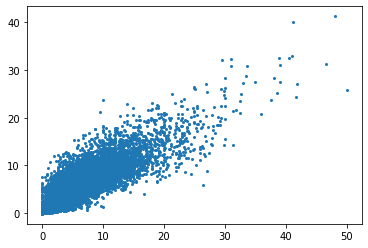

In [44]:
plt.plot(y_train, y_train_pred, ls='None', Marker='.', ms=4)

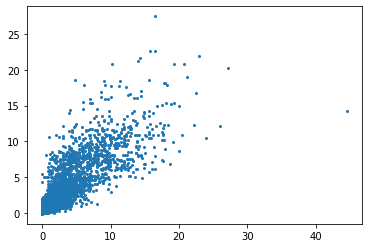

In [45]:
plt.plot(y_test, y_test_pred, ls='None', Marker='.', ms=4)

In [46]:
eye_test=testGroup[(testGroup['ZS']==1) & (testGroup['date']==datetime.date(2021,7,22))][staticFeaturesAll]

to_pca_train=eye_test[staticFeatures]
eye_test=eye_test.drop(staticFeatures, axis=1)
to_pca_train=scaler.transform(to_pca_train)
to_pca_train=pca.transform(to_pca_train)

to_pca_train=pd.DataFrame(to_pca_train, dtype=float)
eye_test.reset_index(drop=True, inplace=True)

eye_test=pd.concat([eye_test, to_pca_train], axis=1)
y_test_pred=Predictor.predict(eye_test)

plt.plot(y_test_pred, testGroup[(testGroup['ZS']==1) & (testGroup['date']==datetime.date(2021,7,22))]['fut_spread'], ls='none', MarkerSize=4, Marker='.')


KeyError: 'ZS'

In [104]:
DataSet.head()

,ordinal_times,localtime,symbol,bid,ask,bidsize,asksize,mid,spread,open,...,median_width,median_nbbo_size,opening_price,closing_price,symbol_type,fut_spread,date,normalized_spread,normalized_fut_spread,recip_ordinal_times
0,0,2021-01-04 14:30:00+00:00,CVS,68.56,68.67,205,1,68.615,0.11,68.74,...,0.01,642.5,67.70,68.30,Common Stock,0.06,2021-01-04,0.001602,0.000874,1.0
1,0,2021-01-04 14:30:00+00:00,BKI,88.71,89.05,17,452,88.880,0.34,88.93,...,0.05,398.0,88.46,88.35,Common Stock,0.30,2021-01-04,0.003818,0.003369,1.0
2,0,2021-01-04 14:30:00+00:00,BEN,24.92,24.96,160,1300,24.940,0.04,25.00,...,0.01,3059.5,24.70,24.99,Common Stock,0.01,2021-01-04,0.001603,0.000401,1.0
3,0,2021-01-04 14:30:00+00:00,VOT,212.19,212.42,200,300,212.305,0.23,212.97,...,0.11,300.0,211.78,212.07,ETP,0.23,2021-01-04,0.001083,0.001083,1.0
4,0,2021-01-04 14:30:00+00:00,OTEX,45.46,45.50,300,200,45.480,0.04,45.90,...,0.02,600.5,45.48,45.46,Common Stock,0.03,2021-01-04,0.000879,0.000659,1.0


In [ ]:
#one_hot_symbol=pd.get_dummies(DataSet['symbol'])
testGroup=DataSet
one_hot_type=pd.get_dummies(testGroup['symbol_type'])
testGroup=testGroup.drop('symbol', axis=1)
#DataSet=DataSet.join(one_hot_symbol)
testGroup=testGroup.drop('symbol_type', axis=1)
testGroup=testGroup.join(one_hot_type)

#ticker_one_hot_feature=list(one_hot_symbol.columns)
type_one_hot_features=list(one_hot_type.columns)

allNumericalFeaturesOneHot=allNumericalFeatures+['ordinal_times']+type_one_hot_features

x_train, x_test, y_train, y_test=train_test_split(testGroup[allNumericalFeaturesOneHot], testGroup['fut_spread'], test_size=0.25, shuffle=True)

to_pca_train=x_train[allNumericalFeatures]
x_train=x_train.drop(allNumericalFeatures, axis=1)
to_pca_test=x_test[allNumericalFeatures]
x_test=x_test.drop(allNumericalFeatures, axis=1)

scaler=StandardScaler()
scaler.fit(to_pca_train)
to_pca_train=scaler.transform(to_pca_train)
to_pca_test=scaler.transform(to_pca_test)
    
pca=PCA(0.95)
pca.fit(to_pca_train)
print(pca.explained_variance_ratio_)
to_pca_train=pca.transform(to_pca_train)
to_pca_test=pca.transform(to_pca_test)

to_pca_train=pd.DataFrame(to_pca_train, dtype=float)
x_train.reset_index(drop=True, inplace=True)

to_pca_test=pd.DataFrame(to_pca_test, dtype=float)
x_test.reset_index(drop=True, inplace=True)

x_train=pd.concat([x_train, to_pca_train], axis=1)
x_test=pd.concat([x_test, to_pca_test], axis=1)

Predictor=RandomForestRegressor(max_depth=5, n_estimators=40).fit(x_train, y_train)
y_train_pred=Predictor.predict(x_train)
y_test_pred=Predictor.predict(x_test)

training_error=np.sqrt(metrics.mean_squared_error(y_train_pred, y_train))/(DataSet['fut_spread'].std())
test_error=np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))/(DataSet['fut_spread'].std())

print(Predictor.score(x_train, y_train))
print(Predictor.score(x_test, y_test))


print(training_error)
print(test_error)

In [ ]:
plt.plot(DataSet[DataSet['symbol_type']=='Common Stock']['median_width'], DataSet[DataSet['symbol_type']=='Common Stock']['fut_spread'],ls='none', ms=4, Marker='.')

In [ ]:
ZS=DataSet[DataSet['symbol']=='ZS'][['fut_spread', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
GS=DataSet[DataSet['symbol']=='GS'][['fut_spread', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
IAC=DataSet[DataSet['symbol']=='IAC'][['fut_spread', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
fig, axs=plt.subplots(1,3, sharex=True, sharey=True)

fig.set_size_inches(20,5)

axs[0].plot(ZS['fut_spread'])
axs[0].set_xlabel('ordinal time')
axs[0].set_ylabel('future spread (normalized)')
axs[0].set_title('ZS')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].plot(GS['fut_spread'])
axs[1].set_xlabel('ordinal time')
axs[1].set_title('GS')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[2].plot(IAC['fut_spread'])
axs[2].set_xlabel('ordinal time')
axs[2].set_title('IAC')
axs[2].set_xscale('log')
axs[2].set_yscale('log')

plt.show()

In [ ]:
plt.plot(ZS['fut_spread'])
plt.plot(GS['fut_spread'])
plt.plot(IAC['fut_spread'])
plt.xscale('log')
plt.yscale('log')

In [ ]:
DataSet['fut_spread_by_width']=DataSet.apply(lambda row: row['fut_spread']/row['median_width'], axis=1)

In [ ]:
fig, axs=plt.subplots(1,3, sharex=True)
fig.set_size_inches(20,5)
ZS=DataSet[DataSet['symbol']=='ZS'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
GS=DataSet[DataSet['symbol']=='GS'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
IAC=DataSet[DataSet['symbol']=='IAC'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
MSFT=DataSet[DataSet['symbol']=='MSFT'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
OPEN=DataSet[DataSet['symbol']=='OPEN'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
REGN=DataSet[DataSet['symbol']=='REGN'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()





axs[0].plot(ZS['fut_spread_by_width'])
axs[0].plot(GS['fut_spread_by_width'])
axs[0].plot(IAC['fut_spread_by_width'])
axs[0].plot(MSFT['fut_spread_by_width'])
axs[0].plot(OPEN['fut_spread_by_width'])
axs[0].plot(REGN['fut_spread_by_width'])
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].plot(2*np.linspace(1,30, num=38)**-0.25, color='black', label='My guess')
axs[0].set_title('Common Stock')
axs[0].set_xlabel('ordinal time')
axs[0].legend()


VOT=DataSet[DataSet['symbol']=='VOT'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
EWJ=DataSet[DataSet['symbol']=='EWJ'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
IWV=DataSet[DataSet['symbol']=='IWV'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
IVV=DataSet[DataSet['symbol']=='IVV'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
IWB=DataSet[DataSet['symbol']=='IWB'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
SPYV=DataSet[DataSet['symbol']=='SPYV'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()



axs[1].plot(VOT['fut_spread_by_width'])
axs[1].plot(EWJ['fut_spread_by_width'])
axs[1].plot(IWV['fut_spread_by_width'])
axs[1].plot(IVV['fut_spread_by_width'])
axs[1].plot(IWB['fut_spread_by_width'])
axs[1].plot(SPYV['fut_spread_by_width'])

axs[1].plot(2*np.linspace(1,30, num=38)**-0.2, color='black')

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_title('ETP')


ING=DataSet[DataSet['symbol']=='ING'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
BIDU=DataSet[DataSet['symbol']=='BIDU'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
XPEV=DataSet[DataSet['symbol']=='XPEV'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
HDB=DataSet[DataSet['symbol']=='HDB'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
NGG=DataSet[DataSet['symbol']=='NGG'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()
LU=DataSet[DataSet['symbol']=='LU'][['fut_spread_by_width', 'spread', 'ordinal_times']].groupby(['ordinal_times']).mean()



axs[2].plot(ING['fut_spread_by_width'])
axs[2].plot(BIDU['fut_spread_by_width'])
axs[2].plot(XPEV['fut_spread_by_width'])
axs[2].plot(HDB['fut_spread_by_width'])
axs[2].plot(NGG['fut_spread_by_width'])
axs[2].plot(LU['fut_spread_by_width'])

axs[2].plot(2*np.linspace(1,30, num=38)**-0.2, color='black')

axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_title('ADR')

plt.show()

In [ ]:
testDataSet=DataSet[(DataSet['normalized_spread']>0) & (DataSet['normalized_fut_spread']>0)]

testDataSet['fut_spread_by_last_spread']=testDataSet.apply(lambda row: row['fut_spread']/row['spread'], axis=1)

In [ ]:
fig, axs=plt.subplots(1,3, sharex=True)
fig.set_size_inches(20,5)

preserved_rows=['fut_spread_by_last_spread', 'spread', 'ordinal_times']
ZS=testDataSet[testDataSet['symbol']=='ZS'][preserved_rows].groupby(['ordinal_times']).mean()
GS=testDataSet[testDataSet['symbol']=='GS'][preserved_rows].groupby(['ordinal_times']).mean()
IAC=testDataSet[testDataSet['symbol']=='IAC'][preserved_rows].groupby(['ordinal_times']).mean()
MSFT=testDataSet[testDataSet['symbol']=='MSFT'][preserved_rows].groupby(['ordinal_times']).mean()
OPEN=testDataSet[testDataSet['symbol']=='OPEN'][preserved_rows].groupby(['ordinal_times']).mean()
REGN=testDataSet[testDataSet['symbol']=='REGN'][preserved_rows].groupby(['ordinal_times']).mean()





axs[0].plot(ZS['fut_spread_by_last_spread'])
axs[0].plot(GS['fut_spread_by_last_spread'])
axs[0].plot(IAC['fut_spread_by_last_spread'])
axs[0].plot(MSFT['fut_spread_by_last_spread'])
axs[0].plot(OPEN['fut_spread_by_last_spread'])
axs[0].plot(REGN['fut_spread_by_last_spread'])
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_title('Common Stock')
axs[0].set_xlabel('ordinal time')


VOT=testDataSet[testDataSet['symbol']=='VOT'][preserved_rows].groupby(['ordinal_times']).mean()
EWJ=testDataSet[testDataSet['symbol']=='EWJ'][preserved_rows].groupby(['ordinal_times']).mean()
IWV=testDataSet[testDataSet['symbol']=='IWV'][preserved_rows].groupby(['ordinal_times']).mean()
IVV=testDataSet[testDataSet['symbol']=='IVV'][preserved_rows].groupby(['ordinal_times']).mean()
IWB=testDataSet[testDataSet['symbol']=='IWB'][preserved_rows].groupby(['ordinal_times']).mean()
SPYV=testDataSet[testDataSet['symbol']=='SPYV'][preserved_rows].groupby(['ordinal_times']).mean()


axs[1].plot(VOT['fut_spread_by_last_spread'])
axs[1].plot(EWJ['fut_spread_by_last_spread'])
axs[1].plot(IWV['fut_spread_by_last_spread'])
axs[1].plot(IVV['fut_spread_by_last_spread'])
axs[1].plot(IWB['fut_spread_by_last_spread'])
axs[1].plot(SPYV['fut_spread_by_last_spread'])



axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_title('ETP')


ING=testDataSet[testDataSet['symbol']=='ING'][preserved_rows].groupby(['ordinal_times']).mean()
BIDU=testDataSet[testDataSet['symbol']=='BIDU'][preserved_rows].groupby(['ordinal_times']).mean()
XPEV=testDataSet[testDataSet['symbol']=='XPEV'][preserved_rows].groupby(['ordinal_times']).mean()
HDB=testDataSet[testDataSet['symbol']=='HDB'][preserved_rows].groupby(['ordinal_times']).mean()
NGG=testDataSet[testDataSet['symbol']=='NGG'][preserved_rows].groupby(['ordinal_times']).mean()
LU=testDataSet[testDataSet['symbol']=='LU'][preserved_rows].groupby(['ordinal_times']).mean()


axs[2].plot(ING['fut_spread_by_last_spread'])
axs[2].plot(BIDU['fut_spread_by_last_spread'])
axs[2].plot(XPEV['fut_spread_by_last_spread'])
axs[2].plot(HDB['fut_spread_by_last_spread'])
axs[2].plot(NGG['fut_spread_by_last_spread'])
axs[2].plot(LU['fut_spread_by_last_spread'])


axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_title('ADR')

plt.show()

In [ ]:
data=deepcopy(testDataSet[testDataSet['symbol']=='OPEN'])
data['log_fut_spread']=data.apply(lambda row: np.log(row['fut_spread']), axis=1)
data['log_med_width']=data.apply(lambda row: np.log(row['median_width']), axis=1)
data['log_ordinal_times']=data.apply(lambda row: np.log(row['ordinal_times']+1), axis=1)

features=['log_med_width', 'ordinal_times']
target='log_fut_spread'

x_train, x_test, y_train, y_test=splitData(data, features, target, 0.25, set_seed=False)

Predictor=Ridge(alpha=0.001).fit(x_train, y_train)
y_train_pred=Predictor.predict(x_train)
y_test_pred=Predictor.predict(x_test)

train_error=np.sqrt(metrics.mean_squared_error(y_train_pred, y_train))/(data['log_fut_spread'].std())

test_error=np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))/(data['log_fut_spread'].std())
print(train_error)
print(test_error)
print(Predictor.score(x_test, y_test))

In [ ]:
testStaticFeatures=staticFeatures
testNumerical=allNumericalFeatures
target='fut_spread'

#one_hot_symbol=pd.get_dummies(DataSet['symbol'])
testGroup=DataSet
one_hot_type=pd.get_dummies(testGroup['symbol_type'])
testGroup=testGroup.drop('symbol', axis=1)
#testGroup=testGroup.join(one_hot_symbol)
testGroup=testGroup.drop('symbol_type', axis=1)
testGroup=testGroup.join(one_hot_type)

#ticker_one_hot_features=list(one_hot_symbol.columns)
type_one_hot_features=list(one_hot_type.columns)

testStaticAll=testStaticFeatures+type_one_hot_features+['ordinal_times']
testNumericalAll=testNumerical+type_one_hot_features+['ordinal_times']

In [34]:
DataSet=pd.read_parquet("spreads_data_train.par")
DataSet=DataSet.sort_values(by='localtime')
tickers=list(DataSet['symbol'].unique())
FeatureSet=pd.read_csv('data_descriptions.csv')
FeatureSet
staticFeatures=list(FeatureSet[(FeatureSet['Category']=='Static') & ((FeatureSet['Type']=='float64') | (FeatureSet['Type']=='int64'))]['Column'])
TandQFeatures=list(FeatureSet[(FeatureSet['Category']=='Trade') | (FeatureSet['Category']=='Quote')]['Column'])
allNumericalFeatures=staticFeatures+TandQFeatures

DataSet=DataSet[DataSet['numEvents']>=0]
DataSet=DataSet[(DataSet['fut_spread']>0) & (DataSet['spread']>0)]

DataSet=DataSet.rename_axis("ordinal_times").reset_index()
DataSet.head()

staticDataSet=DataSet.dropna()
totalDataSet=DataSet

hgbrStaticFeatures=['symbol', 'symbol_type', 'ordinal_times']+staticFeatures
hgbrNumericalFeatures=['symbol', 'symbol_type', 'ordinal_times']+allNumericalFeatures

In [42]:
testStaticFeatures=staticFeatures
testNumerical=allNumericalFeatures
target='fut_spread'

#one_hot_symbol=pd.get_dummies(DataSet['symbol'])
testGroup=staticDataSet
one_hot_type=pd.get_dummies(testGroup['symbol_type'])
testGroup=testGroup.drop('symbol', axis=1)
#testGroup=testGroup.join(one_hot_symbol)
testGroup=testGroup.drop('symbol_type', axis=1)
testGroup=testGroup.join(one_hot_type)

#ticker_one_hot_features=list(one_hot_symbol.columns)
type_one_hot_features=list(one_hot_type.columns)

testStaticAll=testStaticFeatures+type_one_hot_features+['ordinal_times']
testNumericalAll=testNumerical+type_one_hot_features+['ordinal_times']

In [47]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

target='fut_spread'

x_train, x_test, y_train, y_test=splitData(testGroup, testStaticAll, target, 0.1, set_seed=False)

to_pca_train=x_train[staticFeatures]
x_train=x_train.drop(staticFeatures, axis=1)
to_pca_test=x_test[staticFeatures]
x_test=x_test.drop(staticFeatures, axis=1)

scaler=StandardScaler()
scaler.fit(to_pca_train)
to_pca_train=scaler.transform(to_pca_train)
to_pca_test=scaler.transform(to_pca_test)
    
pca=PCA(0.95)
pca.fit(to_pca_train)
print(pca.explained_variance_ratio_)
to_pca_train=pca.transform(to_pca_train)
to_pca_test=pca.transform(to_pca_test)

to_pca_train=pd.DataFrame(to_pca_train, dtype=float)
x_train.reset_index(drop=True, inplace=True)

to_pca_test=pd.DataFrame(to_pca_test, dtype=float)
x_test.reset_index(drop=True, inplace=True)

x_train=pd.concat([x_train, to_pca_train], axis=1)
x_test=pd.concat([x_test, to_pca_test], axis=1)

reg=HistGradientBoostingRegressor().fit(x_train, y_train)


[0.30049969 0.28326596 0.12468561 0.09994455 0.09894358 0.06793264]


In [48]:
y_test_pred=reg.predict(x_test)
print(reg.score(x_test, y_test))
print(np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))/(testGroup['fut_spread'].std()))

0.8207039393323616
0.43505499121316576


In [50]:
x_train, x_test, y_train, y_test=splitData(testGroup, testNumericalAll, target, 0.1, set_seed=False)

to_pca_train=x_train[testNumerical]
x_train=x_train.drop(testNumerical, axis=1)
to_pca_test=x_test[testNumerical]
x_test=x_test.drop(testNumerical, axis=1)

scaler=StandardScaler()
scaler.fit(to_pca_train)
to_pca_train=scaler.transform(to_pca_train)
to_pca_test=scaler.transform(to_pca_test)
    
pca=PCA(0.95)
pca.fit(to_pca_train)
print(pca.explained_variance_ratio_)
to_pca_train=pca.transform(to_pca_train)
to_pca_test=pca.transform(to_pca_test)

to_pca_train=pd.DataFrame(to_pca_train, dtype=float)
x_train.reset_index(drop=True, inplace=True)

to_pca_test=pd.DataFrame(to_pca_test, dtype=float)
x_test.reset_index(drop=True, inplace=True)

x_train=pd.concat([x_train, to_pca_train], axis=1)
x_test=pd.concat([x_test, to_pca_test], axis=1)

reg=HistGradientBoostingRegressor().fit(x_train, y_train)

y_test_pred=reg.predict(x_test)
print(reg.score(x_test, y_test))
print(np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))/(staticDataSet['fut_spread'].std()))






[0.44908592 0.18934761 0.11392411 0.05989628 0.04392829 0.04304131
 0.03509406 0.02511793]
0.8287045045548687
0.393072079334081


In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)



2.7.0


In [67]:
DataSet=pd.read_parquet("spreads_data_train.par")
DataSet=DataSet.sort_values(by='localtime')
tickers=list(DataSet['symbol'].unique())
FeatureSet=pd.read_csv('data_descriptions.csv')
FeatureSet
staticFeatures=list(FeatureSet[(FeatureSet['Category']=='Static') & ((FeatureSet['Type']=='float64') | (FeatureSet['Type']=='int64'))]['Column'])
TandQFeatures=list(FeatureSet[(FeatureSet['Category']=='Trade') | (FeatureSet['Category']=='Quote')]['Column'])
allNumericalFeatures=staticFeatures+TandQFeatures

DataSet=DataSet[DataSet['numEvents']>=0]

DataSet['normalized_spread']=DataSet.apply(lambda row: normalizeSpread(row['spread'],row['ask']), axis=1)
DataSet['normalized_fut_spread']=DataSet.apply(lambda row: normalizeSpread(row['fut_spread'],row['ask']), axis=1)
DataSet=DataSet[(DataSet['fut_spread']>0) & (DataSet['spread']>0)]

DataSet=DataSet.rename_axis("ordinal_times").reset_index()
DataSet.head()

DataSet=DataSet.dropna()

tfStaticFeatures=['ordinal_times']+staticFeatures
tfNumericalFeatures=['ordinal_times']+allNumericalFeatures

In [107]:
symbol='TTD'
target='fut_spread'

data=DataSet[DataSet['symbol']==symbol]

reduced_features=['median_width','avg_daily_volume','volatility','closing_price']

x_train, x_test, y_train, y_test=splitData(data, tfStaticFeatures, target, 0.1, set_seed=False)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(x_train))

first = np.array(x_train[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[2.40e+01 5.22e-01 5.45e+05 3.75e+08 5.26e+05 3.67e+08 1.19e+00 1.13e+00
  9.00e+01 6.88e+02 6.67e+02]]

Normalized: [[ 0.44 -0.63 -0.75 -1.92 -0.51 -1.    0.94  1.06 -0.51  0.56  0.5 ]]


In [152]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [109]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()
history = dnn_model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=100)



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_10 (Normaliza  (None, 11)               23        
 tion)                                                           
                                                                 
 dense_30 (Dense)            (None, 64)                768       
                                                                 
 dense_31 (Dense)            (None, 64)                4160      
                                                                 
 dense_32 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,016
Trainable params: 4,993
Non-trainable params: 23
_________________________________________________________________


In [118]:
plot(history)

NameError: name 'plot' is not defined

In [110]:
y_test_pred = dnn_model.predict(x_test).flatten()

error = (y_test_pred - y_test)**2

test_results['ZS_MSE_reduced'] = (np.sqrt(error.sum()/len(y_test)))/data['fut_spread'].std()

pd.DataFrame(test_results, index=['Certainty Gain over Null Guess']).T

,Certainty Gain over Null Guess
IAC_MSE_full,0.068760
IAC_MSE_static,0.075308
ZS_MSE_full,0.039872
ZS_MSE_static,0.035778
ZS_MSE_reduced,0.027492


In [220]:
data['fut_spread'].std()

0.624254170860794

In [225]:
np.sqrt(((data['fut_spread']-data['fut_spread'].mean())**2).sum()/len(data['fut_spread']))

0.6241715483773558

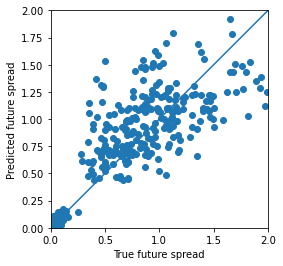

In [113]:
y_test_pred = dnn_model.predict(x_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_test_pred)
plt.xlabel('True future spread')
plt.ylabel('Predicted future spread')
lims = [0, 2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

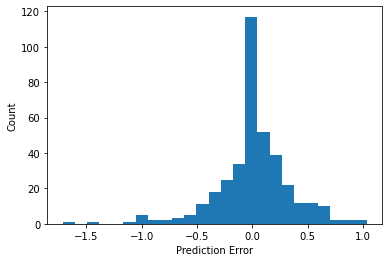

In [114]:
error = (y_test_pred - y_test)
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

In [123]:
error = (y_test_pred - y_test)**2
(np.sqrt(error.sum())/len(y_test))/data['fut_spread'].std()

0.041767233566430154

In [125]:
import random
random_tickers=random.sample(tickers, 100)

In [153]:
test_results_mse_full={}
for ticker in tqdm(random_tickers):
    data=DataSet[DataSet['symbol']==symbol]
    x_train, x_test, y_train, y_test=splitData(data, tfNumericalFeatures, target, 0.1, set_seed=False)
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(x_train))

    dnn_model = build_and_compile_model(normalizer)
    #dnn_model.summary()
    history = dnn_model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=100)
    
    y_test_pred = dnn_model.predict(x_test).flatten()

    error = (y_test_pred - y_test)**2

    test_results_mse_full[ticker] = (np.sqrt(error.sum())/len(y_test))/data['fut_spread'].std()

100%|██████████| 100/100 [13:06<00:00,  7.87s/it]


In [143]:
np.mean(list(test_results.values()))

0.02914405129867438

In [148]:
np.mean(list(test_results.values()))

0.02981579061315427

In [151]:
np.mean(list(test_results_mae_full.values()))

0.030776261827866108

In [154]:
np.mean(list(test_results_mse_full.values()))

0.03104810409459318

In [201]:
DataSet['dayofweek']=DataSet['localtime'].dt.dayofweek

In [167]:
from sklearn.preprocessing import OrdinalEncoder
test=(DataSet['localtime'].dt.time)

In [164]:
np.array(DataSet['localtime'].dt.time)

array([datetime.time(14, 30), datetime.time(14, 30),
       datetime.time(14, 30), ..., datetime.time(19, 50),
       datetime.time(19, 50), datetime.time(19, 50)], dtype=object)

In [174]:
test.value

AttributeError: 'Series' object has no attribute 'value'

In [182]:
DataSet['valuetime'] = DataSet['time'].apply(lambda x: x.value)

In [179]:
DataSet['time'] = pd.to_datetime(DataSet['localtime'])

In [197]:
DataSet['time']=DataSet['localtime'].dt.time

In [200]:
DataSet['time'].unique()

array([datetime.time(14, 30), datetime.time(14, 40),
       datetime.time(14, 50), datetime.time(15, 0), datetime.time(15, 10),
       datetime.time(15, 20), datetime.time(15, 30),
       datetime.time(15, 40), datetime.time(15, 50), datetime.time(16, 0),
       datetime.time(16, 10), datetime.time(16, 20),
       datetime.time(16, 30), datetime.time(16, 40),
       datetime.time(16, 50), datetime.time(17, 0), datetime.time(17, 10),
       datetime.time(17, 20), datetime.time(17, 30),
       datetime.time(17, 40), datetime.time(17, 50), datetime.time(18, 0),
       datetime.time(18, 10), datetime.time(18, 20),
       datetime.time(18, 30), datetime.time(18, 40),
       datetime.time(18, 50), datetime.time(19, 0), datetime.time(19, 10),
       datetime.time(19, 20), datetime.time(19, 30),
       datetime.time(19, 40), datetime.time(19, 50), datetime.time(20, 0),
       datetime.time(20, 10), datetime.time(20, 20),
       datetime.time(20, 30), datetime.time(20, 40),
       datetime.time

In [202]:
DataSet['dayofweek']

0          0
1          0
2          0
3          0
4          0
          ..
3366899    4
3366900    4
3366901    4
3366902    4
3366903    4
Name: dayofweek, Length: 3364705, dtype: int64

In [213]:
dayofweekspread=DataSet[['normalized_fut_spread', 'dayofweek', 'ordinal_times']].groupby(['dayofweek','ordinal_times']).mean()

In [206]:
DataSet['dayofweek']

0          0
1          0
2          0
3          0
4          0
          ..
3366899    4
3366900    4
3366901    4
3366902    4
3366903    4
Name: dayofweek, Length: 3364705, dtype: int64

In [214]:
dayofweekspread

normalized_fut_spread
dayofweek ordinal_times                       
0         0                           0.001382
          1                           0.001127
          2                           0.000971
          3                           0.000865
          4                           0.000825
...                                        ...
4         34                          0.000470
          35                          0.000455
          36                          0.000436
          37                          0.000510
          38                          0.000477

[195 rows x 1 columns]

In [211]:
dayofweekspread.index

MultiIndex([(0,  0),
            (0,  1),
            (0,  2),
            (0,  3),
            (0,  4),
            (0,  5),
            (0,  6),
            (0,  7),
            (0,  8),
            (0,  9),
            ...
            (4, 29),
            (4, 30),
            (4, 31),
            (4, 32),
            (4, 33),
            (4, 34),
            (4, 35),
            (4, 36),
            (4, 37),
            (4, 38)],
           names=['dayofweek', 'ordinal_times'], length=195)

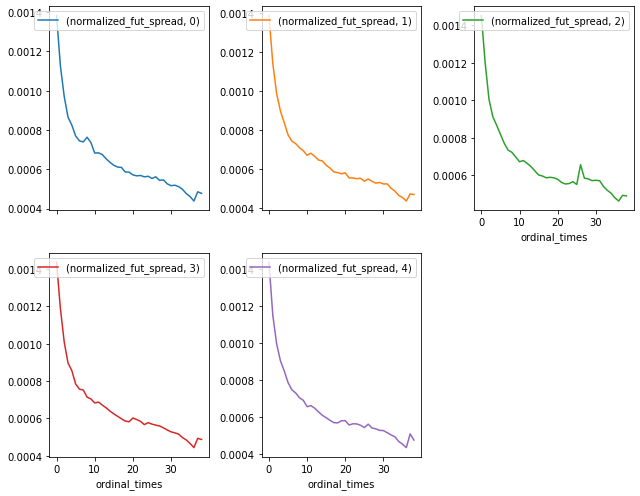

In [217]:
ax = dayofweekspread.unstack(level=0).plot(kind='line', subplots=True, rot=0, figsize=(9, 7), layout=(2, 3))
plt.tight_layout()

In [226]:
DataSet[DataSet['symbol'=='LAD']]['symbol_type']

KeyError: False

In [228]:
DataSet[DataSet['symbol']=='LAD']['']

,ordinal_times,localtime,symbol,bid,ask,bidsize,asksize,mid,spread,open,...,opening_price,closing_price,symbol_type,fut_spread,date,normalized_spread,normalized_fut_spread,time,valuetime,dayofweek
568,0,2021-01-04 14:30:00+00:00,LAD,295.51,296.74,2,136,296.125,1.23,296.130,...,291.35,292.67,Common Stock,1.91,2021-01-04,0.004145,0.006437,14:30:00,1609770600000000000,0
1762,1,2021-01-04 14:40:00+00:00,LAD,293.87,295.78,30,171,294.825,1.91,293.890,...,291.35,292.67,Common Stock,1.46,2021-01-04,0.006458,0.004936,14:40:00,1609771200000000000,0
1849,2,2021-01-04 14:50:00+00:00,LAD,290.54,292.00,1,3,291.270,1.46,292.705,...,291.35,292.67,Common Stock,0.98,2021-01-04,0.005000,0.003356,14:50:00,1609771800000000000,0
3285,3,2021-01-04 15:00:00+00:00,LAD,290.50,291.48,206,7,290.990,0.98,291.480,...,291.35,292.67,Common Stock,1.23,2021-01-04,0.003362,0.004220,15:00:00,1609772400000000000,0
4366,4,2021-01-04 15:10:00+00:00,LAD,292.00,293.23,20,24,292.615,1.23,290.610,...,291.35,292.67,Common Stock,0.83,2021-01-04,0.004195,0.002831,15:10:00,1609773000000000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3362432,34,2021-07-30 19:10:00+00:00,LAD,376.60,377.30,1,157,376.950,0.70,376.810,...,378.03,381.52,Common Stock,0.77,2021-07-30,0.001855,0.002041,19:10:00,1627672200000000000,4
3363446,35,2021-07-30 19:20:00+00:00,LAD,375.93,376.70,6,424,376.315,0.77,377.250,...,378.03,381.52,Common Stock,0.57,2021-07-30,0.002044,0.001513,19:20:00,1627672800000000000,4
3364206,36,2021-07-30 19:30:00+00:00,LAD,376.67,377.24,100,47,376.955,0.57,376.890,...,378.03,381.52,Common Stock,0.69,2021-07-30,0.001511,0.001829,19:30:00,1627673400000000000,4
3365793,37,2021-07-30 19:40:00+00:00,LAD,375.78,376.47,58,333,376.125,0.69,376.625,...,378.03,381.52,Common Stock,0.36,2021-07-30,0.001833,0.000956,19:40:00,1627674000000000000,4
